# Workplace Payment Compliance Analysis

# Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pandasql import sqldf
from datetime import datetime,timedelta

import regex as re


# Getting the Data

In [2]:
xl = pd.ExcelFile("Sample Super Data.xlsx")

disbursements = pd.read_excel('Sample Super Data.xlsx', sheet_name= xl.sheet_names[0])
payslips = pd.read_excel('Sample Super Data.xlsx', sheet_name= xl.sheet_names[1])
paycodes = pd.read_excel('Sample Super Data.xlsx', sheet_name = xl.sheet_names[2]) 

# Loading the data

In [3]:
disbursements

,sgc_amount,payment_made,pay_period_from,pay_period_to,employee_code
0,763.66,2017-11-01T00:00:00,2017-09-25T00:00:00,2017-10-22T00:00:00,1155
1,1110.76,2017-08-09T00:00:00,2017-06-19T00:00:00,2017-07-30T00:00:00,1155
2,763.66,2017-10-04T00:00:00,2017-08-28T00:00:00,2017-09-24T00:00:00,1155
3,763.66,2017-11-30T00:00:00,2017-10-23T00:00:00,2017-11-19T00:00:00,1155
4,763.66,2017-09-06T00:00:00,2017-07-31T00:00:00,2017-08-27T00:00:00,1155
...,...,...,...,...,...
70,988.26,2018-01-10T00:00:00,2017-11-20T00:00:00,2017-12-31T00:00:00,1963
71,658.84,2018-05-03T00:00:00,2018-03-26T00:00:00,2018-04-22T00:00:00,1963
72,658.84,2017-09-06T00:00:00,2017-07-31T00:00:00,2017-08-27T00:00:00,1963
73,744.49,2017-11-30T00:00:00,2017-10-23T00:00:00,2017-11-19T00:00:00,1963


In [4]:
payslips

,payslip_id,end,employee_code,code,amount
0,10d3e5e3-2556-4f56-8053-6b1f39975ea1,2018-01-14,1155,13 - Public Hol,401.92
1,10d3e5e3-2556-4f56-8053-6b1f39975ea1,2018-01-14,1155,T997 - Term G - Long Service Lve Post 17/8/93,17855.96
2,10d3e5e3-2556-4f56-8053-6b1f39975ea1,2018-01-14,1155,T998 - Term G - Lve Loading Post 17/8/93,371.38
3,10d3e5e3-2556-4f56-8053-6b1f39975ea1,2018-01-14,1155,T999 - Term G - Annual Lve Post 17/8/93,2122.18
4,3ff7c572-49f1-4a43-abb4-b09142b26540,2018-01-14,1963,1 - Normal,1733.80
...,...,...,...,...,...
609,a76db5bb-02b9-46ac-b769-740d8a14dece,2018-04-22,2355,A012 - Pager/On call,299.88
610,a76db5bb-02b9-46ac-b769-740d8a14dece,2018-04-22,2355,A042 - L - TRAVEL ALLOWANCE,360.00
611,a76db5bb-02b9-46ac-b769-740d8a14dece,2018-04-22,2355,P001 - Co. Super 9.5%,393.63
612,064d1009-ed04-4227-b82e-be4bd764d0bf,2018-04-22,50015418,1 - Normal,4119.23


In [5]:
paycodes

,pay_code,ote_treament
0,10 - Annual Lve,OTE
1,11 - Sck/Pers,OTE
2,13 - Public Hol,OTE
3,14 - LWOP,Not OTE
4,15 - A/L Cash Out,OTE
5,1 - Normal,OTE
6,2 - O/T 1.5,Not OTE
7,31 - Training,OTE
8,3 - O/T 2.0,Not OTE
9,43 - Travel Payable,Not OTE


# Data Cleaning

In [6]:
def get_unique_cols(df):
    '''
    Function to get unique column
    '''
    unique_cols = []
    for col in list(df.columns):
        if len(df[col].unique()) == df.shape[0]:
            unique_cols.append(col)
    if len(unique_cols) == 0:
        return "No unique columns"
    else:
        return unique_cols
def get_ote_dict(x):
    '''
    getting ote dict
    '''
    ote = {}
    for i in list(df['ote_treatment'].unique()):
        ote[i] = []
    return ote

def change_to_datetime(df):
    df['pay_period_from'] = pd.to_datetime(disbursements['pay_period_from'])
    df['pay_period_to'] = pd.to_datetime(disbursements['pay_period_to'])
    df['payment_made'] = pd.to_datetime(disbursements['payment_made'])
    return df


def change_to_quarter(df):
    
    
    
    # https://stackoverflow.com/questions/50459301/how-to-convert-dates-to-quarters-in-python
    # df['date'].dt.to_period('Q')
    df['pay_period_from_quarter'] = df['pay_period_from'].dt.to_period('Q')
    df['pay_period_to_quarter'] = df['pay_period_to'].dt.to_period('Q')
    df['payment_made_quarter'] = df['payment_made'].dt.to_period('Q')

    return df

def super_payable(amount):
    
    super_payable = amount * 0.095
    return super_payable

def ote_amount(df):
    if df['ote_treatment'] == 'OTE':
        return df['amount'] * 1.095 
    else:
        return df['amount']

def get_normal_days(dict_counts):
    '''
    To identify when the payment from by getting the normal number of days gap
    '''

    # subtract a day from a date
    # from datetime import datetime,timedelta
    # d = dateime.today() - timedelta(days = days_to_subtract)
    
    ks = []
    vs = []
    for k, v in dict_counts.items():
        ks.append(k)
        vs.append(v)
    normal_period_days = ks[vs.index(max(vs))]
    return normal_period_days

def variance(super_payable, sgc_amt):
    '''
    This function is to calculate what was payable and what was disbursed.
    '''
    pattern= re.compile('\d+\.\d+')
    payable_list = []
    for i in list(super_payable):
        str_i = str(i)
        if pattern.match(str_i):
            payable_list.append(i)
        else:
            payable_list.append(0)
    sum_payable = sum(payable_list)

    sgc_list = []
    for i in list(sgc_amt):
        str_i = str(i)
        if pattern.match(str_i):
            sgc_list.append(i)
        else:
            sgc_list.append(0)
    sum_sgc = sum(sgc_list)
    variance = sum_payable / sum_sgc
    return variance
    
    
        
payslips.rename(
    columns = {
        'code':'pay_code'
    },
    inplace = True
)

paycodes.rename(
    columns = {
        'ote_treament' : 'ote_treatment'
    },
    inplace = True
)


In [7]:
disbursements = change_to_datetime(disbursements)
disbursements.head()

,sgc_amount,payment_made,pay_period_from,pay_period_to,employee_code
0,763.66,2017-11-01,2017-09-25,2017-10-22,1155
1,1110.76,2017-08-09,2017-06-19,2017-07-30,1155
2,763.66,2017-10-04,2017-08-28,2017-09-24,1155
3,763.66,2017-11-30,2017-10-23,2017-11-19,1155
4,763.66,2017-09-06,2017-07-31,2017-08-27,1155


In [8]:
payslips.head()

,payslip_id,end,employee_code,pay_code,amount
0,10d3e5e3-2556-4f56-8053-6b1f39975ea1,2018-01-14,1155,13 - Public Hol,401.92
1,10d3e5e3-2556-4f56-8053-6b1f39975ea1,2018-01-14,1155,T997 - Term G - Long Service Lve Post 17/8/93,17855.96
2,10d3e5e3-2556-4f56-8053-6b1f39975ea1,2018-01-14,1155,T998 - Term G - Lve Loading Post 17/8/93,371.38
3,10d3e5e3-2556-4f56-8053-6b1f39975ea1,2018-01-14,1155,T999 - Term G - Annual Lve Post 17/8/93,2122.18
4,3ff7c572-49f1-4a43-abb4-b09142b26540,2018-01-14,1963,1 - Normal,1733.80


In [9]:
payslips = paycodes.join(payslips.set_index('pay_code'), how = 'inner', on = 'pay_code')
payslips['payment_end_quarter'] = payslips['end'].dt.to_period('Q')
payslips['amount_ote'] = payslips.apply(lambda x:ote_amount(x), axis = 1)
payslips

,pay_code,ote_treatment,payslip_id,end,employee_code,amount,payment_end_quarter,amount_ote
0,10 - Annual Lve,OTE,3ff7c572-49f1-4a43-abb4-b09142b26540,2018-01-14,1963,1387.04,2018Q1,1518.80880
0,10 - Annual Lve,OTE,1f725d94-9e6b-474b-8b31-43558ecc3589,2018-01-14,50015418,867.21,2018Q1,949.59495
0,10 - Annual Lve,OTE,5ba90c59-86d6-4f71-9e96-7ad6f280dcaf,2017-12-03,50015418,433.60,2017Q4,474.79200
0,10 - Annual Lve,OTE,933f4a3e-22a4-4c1c-8e5b-32d35247a68e,2018-09-09,2355,2398.88,2018Q3,2626.77360
0,10 - Annual Lve,OTE,b18210c2-b56d-4fee-a44d-23762cfbfa82,2018-02-11,2355,327.12,2018Q1,358.19640
...,...,...,...,...,...,...,...,...
24,T998 - Term G - Lve Loading Post 17/8/93,Not OTE,8078d7ea-e93f-4839-9a9d-07e36c4f9939,2019-12-29,50015418,1215.15,2019Q4,1215.15000
24,T998 - Term G - Lve Loading Post 17/8/93,Not OTE,35c96e11-2f0d-4ebd-976c-b122e2587bce,2019-06-28,2355,1566.08,2019Q2,1566.08000
25,T999 - Term G - Annual Lve Post 17/8/93,Not OTE,10d3e5e3-2556-4f56-8053-6b1f39975ea1,2018-01-14,1155,2122.18,2018Q1,2122.18000
25,T999 - Term G - Annual Lve Post 17/8/93,Not OTE,8078d7ea-e93f-4839-9a9d-07e36c4f9939,2019-12-29,50015418,6943.71,2019Q4,6943.71000


In [10]:
disbursements = change_to_datetime(disbursements)
disbursements = change_to_quarter(disbursements)

# Visualisations

In [11]:
disbursements['period_gap_days'] = disbursements['pay_period_to']- disbursements['pay_period_from']
disbursements['period_gap_days'] = disbursements['period_gap_days'].apply(lambda x:str(x).split()[0]).astype('int64')

normal_period_days = get_normal_days(dict(disbursements['period_gap_days'].value_counts()))
payslips['from'] = payslips['end'] - timedelta(days = normal_period_days)
disbursements['pay_period_from'] = disbursements['pay_period_to'] -  timedelta(days = normal_period_days)

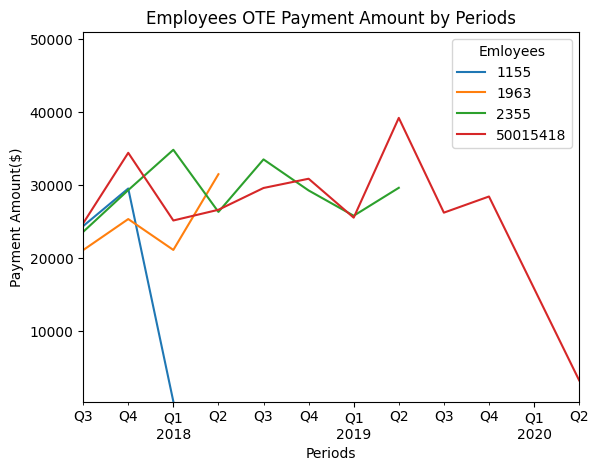

In [12]:
ote_payslips = payslips[payslips['ote_treatment']=='OTE']
ote_payslips = ote_payslips.groupby(['payment_end_quarter', 'employee_code'])['amount'].sum()
ote_payslips_df = pd.DataFrame(ote_payslips)
ote_payslips.unstack(1).plot(kind = 'line')
plt.ylim(min(ote_payslips_df['amount'])-10, max(ote_payslips_df['amount'])*1.3)
plt.xlabel('Periods')
plt.ylabel('Payment Amount($)')
plt.title('Employees OTE Payment Amount by Periods')
plt.legend(title = 'Emloyees')
plt.show();

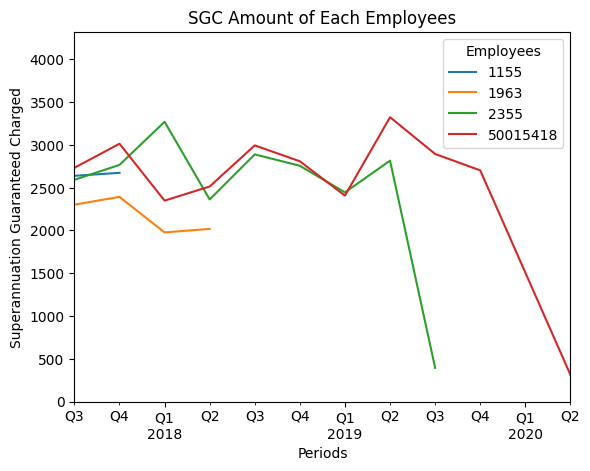

In [13]:
sgc_sum = disbursements.rename(columns = {'pay_period_to_quarter':'payment_end_quarter'}).groupby(['payment_end_quarter','employee_code'])['sgc_amount'].sum()
sgc_sum_df = pd.DataFrame(sgc_sum)
sgc_sum.unstack(1).plot(kind = 'line')
plt.ylim(0, max(sgc_sum_df['sgc_amount'])*1.3)
plt.ylabel('Superannuation Guaranteed Charged')
plt.xlabel('Periods')
plt.title('SGC Amount of Each Employees')
plt.legend(title = 'Employees')
plt.show();

### OTE Employee Amount & Superannuation Guaranteed Charged

The graphs above indicates that the payment/disbursement received by employees who departed in the last quarter of their employment was notably lower compared to the preceding quarter. This decrease prompted the first employee to leave the company.
Additionally, the Superannuation guaranteed and amount of OTE Payment to the last two employees who left the company was highly inconsistent, which also contributed to their decision to leave.that 

In [14]:
payslips_amount = payslips.groupby(['payment_end_quarter', 'employee_code'])['amount'].sum()
payslips_amount_df = pd.DataFrame(payslips_amount)
payslips_amount_df['super_payable'] = payslips_amount_df['amount'].apply(lambda x:super_payable(x))

df_quarterly = payslips_amount_df.reset_index().join(sgc_sum_df, on = ['payment_end_quarter', 'employee_code'])
df_quarterly = df_quarterly.join(ote_payslips_df.rename(columns = {'amount':'ote_amount'}), on = ['payment_end_quarter','employee_code'])
df_quarterly

,payment_end_quarter,employee_code,amount,super_payable,sgc_amount,ote_amount
0,2017Q3,1155,27475.60,2610.18200,2638.08,24396.73
1,2017Q3,1963,23085.48,2193.12060,2301.07,21108.96
2,2017Q3,2355,32731.40,3109.48300,2591.52,23602.52
3,2017Q3,50015418,27120.26,2576.42470,2731.62,24772.29
4,2017Q4,1155,32617.73,3098.68435,2672.81,29534.91
5,2017Q4,1963,28100.34,2669.53230,2391.59,25356.75
6,2017Q4,2355,39683.02,3769.88690,2765.41,29319.54
7,2017Q4,50015418,39389.20,3741.97400,3013.00,34420.20
8,2018Q1,1155,20751.44,1971.38680,NaN,401.92
9,2018Q1,1963,23109.43,2195.39585,1976.52,21132.91


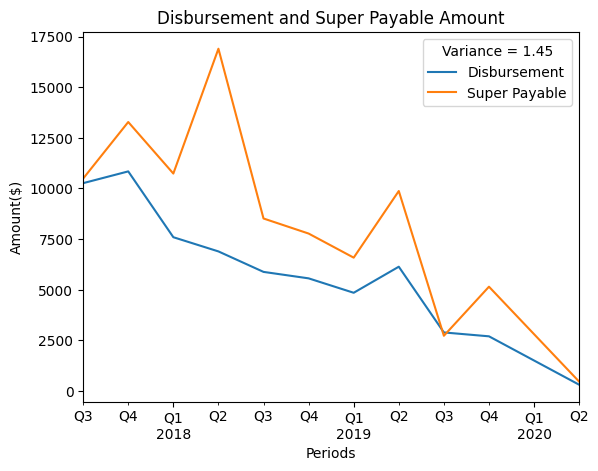

In [15]:
var = variance(df_quarterly['super_payable'], df_quarterly['sgc_amount'])
df_quarterly.groupby(['payment_end_quarter'])[['sgc_amount','super_payable']].sum().plot(kind = 'line')
plt.xlabel('Periods')
plt.ylabel('Amount($)')
plt.title('Quarterly Disbursement and Super Payable Amount')
plt.legend(title = f'Variance = {round(var, 2)}', labels = ['Disbursement', 'Super Payable'])
plt.show();

### Super Payable Amount

Based on the graph depicting Quarterly Disbursement and Super Payable Amount, a significant disparity between the appropriate payable super and disbursement in the 2nd quarter of 2018 was observed. This discrepancy led to the departure of the last two employees, primarily due to workplace compliance issues particularly in the context of receiving appropriate payment.


